# Optimizing rho and l2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from echo import esn

In [46]:
# Experiments with rho, with fixed normalization strength

data = esn.Data.create_source('lorenz')

points_to_skip = 300
training_signal_length = 10000
test_length = 500
n_units = 100
n_edges = 500
n_experiments = 5

rhos = [None, 0.6, 0.8, 1.0, 1.2]
l2s = [0, 0.0001, 0.0003, 0.001]

loss_train = np.zeros((len(rhos), len(l2s), n_experiments))
loss_test = np.zeros((len(rhos), len(l2s), n_experiments))

seeds = np.random.uniform(size=n_experiments) # We always train on same data, but with different networks

for (i_rho, rho) in enumerate(rhos):
    for (i_l2, l2) in enumerate(l2s):
        for i_exp in range(n_experiments):
            x1,y1 = data.generate(points_to_skip + training_signal_length, seed=seeds[i_exp])
            x2,y2 = data.generate(points_to_skip + training_signal_length, seed=1)

            model = esn.Reservoir(n_units, n_edges=n_edges, rho=rho, l2=l2, network_type='erdos')
            model.fit(x1, y1, skip=points_to_skip)

            # Training data loss    
            z = model.predict(x1, length=points_to_skip+test_length)     
            loss_train[i_rho, i_l2, i_exp] = esn.utils.loss(y1[points_to_skip:(points_to_skip+test_length)], z[points_to_skip:])        

            # Testing loss        
            z = model.predict(x2, length=points_to_skip+test_length)     
            loss_test[i_rho, i_l2, i_exp] = esn.utils.loss(y2[points_to_skip:(points_to_skip+test_length)], z[points_to_skip:])
            print('.', end='')
        print(';', end='')
    print('|', end='')
print('Done')

.....;.....;.....;.....;|.....;.....;.....;.....;|.....;.....;.....;.....;|.....;.....;.....;.....;|.....;.....;.....;.....;|Done


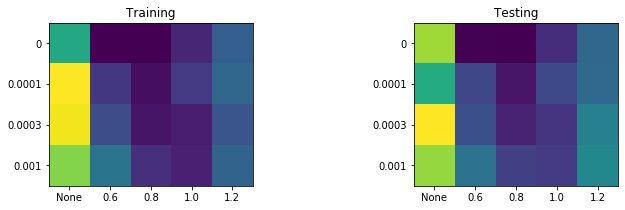

In [47]:
# 2D heatplots of both hyperparameters
def plot2d(x, y, z, label=None):
    plt.imshow(z.T) # Important: matrices have columns first :)
    plt.xticks(np.arange(len(x)), labels=[str(e) for e in x])
    plt.yticks(np.arange(len(y)), labels=[str(e) for e in y])
    plt.title(label)

plt.figure(figsize=(12,3))
plt.subplot(121)
lts = np.mean(loss_train, axis=2)
plot2d(rhos, l2s, lts, 'Training')
plt.subplot(122)
lss = np.mean(loss_test, axis=2)
plot2d(rhos, l2s, lss, 'Testing')

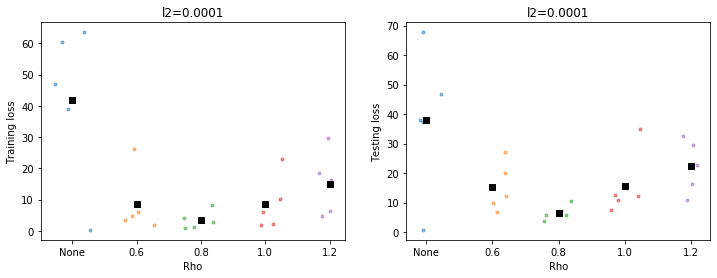

In [49]:
# Transsections
def plot1d(x, y, xlabel=None, ylabel=None, title=None):
    y = np.squeeze(y) # We expect sngleton dimensions here
    xticklabels = [str(e) for e in x]    
    for i,label in enumerate(x):
        plt.plot(i + np.random.uniform(size=y.shape[1])*0.6 - 0.3, y[i,:], '.', alpha=0.5)
        plt.plot(i, np.mean(y[i,:]), 'sk')
    plt.xticks(np.arange(len(x)), labels=xticklabels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
        
plt.figure(figsize=(12,4))
plt.subplot(121)
plot1d(rhos, loss_train[:,1,:], 'Rho', 'Training loss', f'l2={l2s[1]}')
plt.subplot(122)
plot1d(rhos, loss_test[:,1,:], 'Rho', 'Testing loss', f'l2={l2s[1]}')

# Notes from Mar 13, 2021

### Observations for N=100, E=200, Erdos

* No regularization:
 * Optimum of ~30 achieved at ρ=0.2-0.4
 * Testing loss < training loss
* Regularization 0.001:
 * Optimum at ρ=1
 * Higher loss (about 40)
* Regularization 0.01:
 * Much higher loss (about 50)
 * Optimum at ρ~0.8
 * Testing loss still lower than training loss
* l2=0.001, but E=300 
 * Very similar pic, similar optimal rho, but loss much lower (for l2=0.001, from 50 moved to 35)
* l2=0.001, but E=500 
 * Very similar to previous one.
* l2=0.01, E=500
 * Similar pattern, but higher loss (40 instead of 35).
 


### Observations for N=100, E=200, WS

* No regularization:
 * With no regularization, loss is minimal for ρ=0.6 (about 40). Round 60 boh for extremely low and high ρ.
 * When ρ is not rescaled (set to None), for training data, some near=0 losses are achievable. But for testing data they explode. Extreme overfitting?
* Regularizatoin 0.0001
 * Optimum of ~40 (so similar to no regularization), but at rho=1.0 (so more similar to 0.01).
 * Testing loss substantially lower than training loss (~60) 🤔
* Regularization 0.01:
 * Loss is actually higher, with minimum of about 4 achieved for ρ of 1.2.
 * Same pattern for "free rho": great training loss, horrible testing.
* Regularizatoin 0.02:
 * near-constant loss of ~50. Obviously, signal is just suppressed at this point.